<a href="https://colab.research.google.com/github/zairapg/hiperblog/blob/main/Actividad_4_Implementacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



   **Implementacion de la Hipotesis**

   Zaira Idaly Pizo Gurrute




In [1]:
!pip install ucimlrepo
!pip install openpyxl

In [2]:
# Carga de librerías y lectura del archivo que contiene los datos

import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import openpyxl as xl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


# 1. Se realiza el cargue del conjunto de datos en un data frame de pandas (data).


from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# metadata
print(online_retail.metadata)

# variable information
print(online_retail.variables)


# Crear un DataFrame de pandas con las características
data = pd.DataFrame(X)

# Si hay etiquetas (targets), puedes agregarlas al DataFrame
data['Target'] = y


# Imprimir los primeros registros para verificar
print(data.head())





{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

## 1. Analisis Exploratorio de los Datos


In [3]:
#Cuál es el número de registros? #Cuál es el número de atributos?

shape = data.shape
print ('Se establece el numero de registros y numero de atributos en su orden',shape)

Se establece el numero de registros y numero de atributos en su orden (541909, 7)


In [4]:
#Cual es el tipo de los atributos?
print ('Para el total de atributos se identifica el tipo de dato por cada atributo')
data.dtypes

Para el total de atributos se identifica el tipo de dato por cada atributo


,0
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object
Target,object


In [5]:
#Medida de centralidad y desviación para atributos numéricos:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


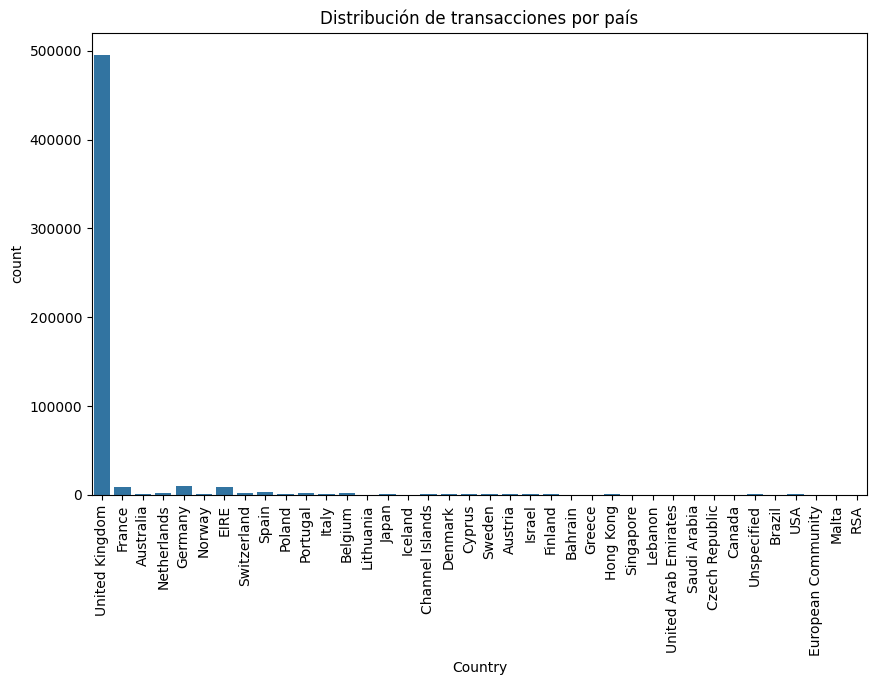

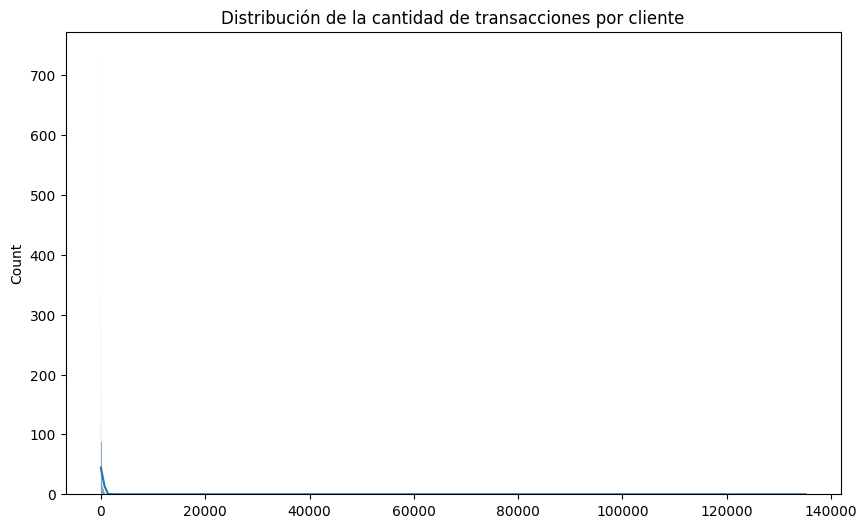

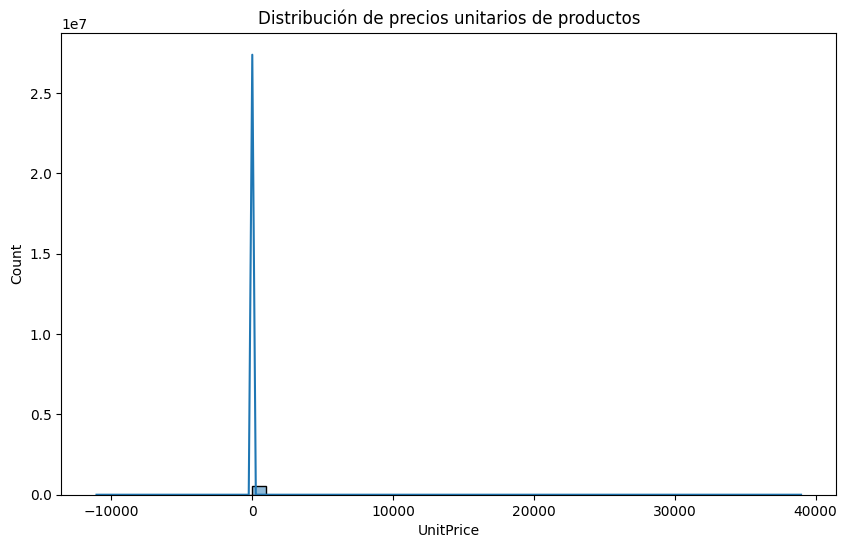

In [6]:
# Distribución de las transacciones por país
plt.figure(figsize=(10,6))
sns.countplot(x='Country', data=data)
plt.xticks(rotation=90)
plt.title('Distribución de transacciones por país')
plt.show()


# Ver la cantidad de transacciones por cliente
data['CustomerID'] = data['CustomerID'].fillna(0)  # Para evitar problemas con los NaN
customer_count = data.groupby('CustomerID').size()
plt.figure(figsize=(10,6))
sns.histplot(customer_count, kde=True)
plt.title('Distribución de la cantidad de transacciones por cliente')
plt.show()


# Visualizar el precio unitario de los productos vendidos
plt.figure(figsize=(10,6))
sns.histplot(data['UnitPrice'], kde=True, bins=50)
plt.title('Distribución de precios unitarios de productos')
plt.show()



In [7]:
#Medida de centralidad para atributos categóricos:
data.mode()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Target
0,WHITE HANGING HEART T-LIGHT HOLDER,1,10/31/2011 14:41,1.25,0.0,United Kingdom,NaN


In [8]:
# Cual es el máximo de datos faltantes en un mismo registro?
# Si hay registros a los que les faltan muchos valores, es mejor eliminarlos.
max(data.isnull().sum(axis=1))

2

In [9]:
#Cuantos datos faltantes hay por cada atributo?
data.isnull().sum()

,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
Target,541909


In [10]:
#Cuantos registros hay por cada clase? es decir, por cada valor del atributo de salida?

print(data['Target'].value_counts())

Series([], Name: count, dtype: int64)


## 2.Procesacimiento de los datos
De acuerdo a lo observado en la etapa 1, se define una secuencia de actividades que modifican los datos para eliminar las situaciones que puedan ser causa de fallo o deficiencia en el proceso de aprendizaje. En este caso se van a realizar las siguientes actividades:


1.   Completar los datos faltantes utilizando la media para atributos numéricos y la moda para atributos categóricos.
2.   Convertir los atributos categóricos a escala numérica.
3.   Normalizar los valores de algunos los atributos.
4.   Balancear las clases eliminando registros de la clase mayoritaria.









Limpieza de valores nulos:
El dataset tiene algunos valores nulos y valores de cantidad igual a cero. Debemos tratarlos

In [11]:
# Eliminamos las filas con valores nulos en 'Description' y 'CustomerID'
data.dropna(subset=['Description', 'CustomerID'], inplace=True)

# Llenar valores nulos en 'Description' con el valor 'Desconocido'
data['Description'].fillna('Desconocido', inplace=True)

# Eliminamos registros con cantidad igual a cero
data= data[data['Quantity'] > 0]

# Rellenamos los valores nulos en 'Country' con un valor genérico o eliminar si es necesario
data['Country'].fillna('Desconocido', inplace=True)

# Verificar si hay algún valor nulo restante
print(data.isnull().sum())

Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID          0
Country             0
Target         530693
dtype: int64


<ipython-input-11-7b93a7ec6afe>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Description'].fillna('Desconocido', inplace=True)
<ipython-input-11-7b93a7ec6afe>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

Conversión de tipos de datos:
El campo InvoiceDate es una cadena, pero debería ser un tipo de dato datetime. Además, el precio y la cantidad deben ser convertidos a valores numéricos.

In [12]:
# Convertir InvoiceDate a datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Convertir 'UnitPrice' a numérico
data['UnitPrice'] = pd.to_numeric(data['UnitPrice'], errors='coerce')

# Convertir 'Quantity' a numérico
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')


Cálculo de variables adicionales:En este caso, podemos crear una columna de "Total" que sea el precio total de cada transacción.

In [13]:

# Crear una nueva columna con el valor total de la compra (Quantity * UnitPrice)
data['TotalValue'] = data['Quantity'] * data['UnitPrice']


In [14]:
data_clientes = data[['CustomerID', 'TotalValue', 'Quantity']]

In [15]:
# Crear las características para cada cliente
data_clientes = data_clientes.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()

#Normalizacion

scaler = StandardScaler()
data_clientes_scaled = scaler.fit_transform(data_clientes[['TotalValue', 'Quantity']])


## Estimacion de los cluster

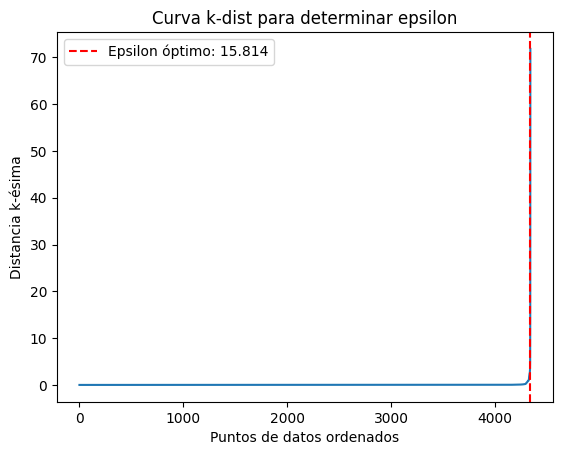

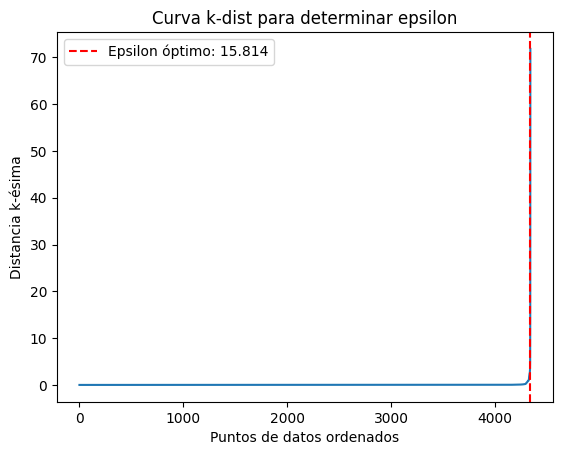

In [18]:
min_samples = 6
neigh = NearestNeighbors(n_neighbors=min_samples)
neigh.fit(data_clientes_scaled)

# Calcular las distancias a los k vecinos más cercanos
distances, indices = neigh.kneighbors(data_clientes_scaled)

# Ordenar las distancias
sorted_distances = np.sort(distances[:, min_samples-1])

# Calcular la segunda derivada para encontrar el punto de inflexión
dd = np.diff(sorted_distances, 2)
optimal_eps = sorted_distances[np.argmax(dd) + 1]  # +1 para compensar la derivada

# Graficar la curva k-dist
plt.plot(sorted_distances)
plt.axvline(x=np.argmax(dd) + 1, color='r', linestyle='--', label=f'Epsilon óptimo: {optimal_eps:.3f}')
plt.xlabel("Puntos de datos ordenados")
plt.ylabel("Distancia k-ésima")
plt.title("Curva k-dist para determinar epsilon")
plt.legend()
plt.show()

# Ordenar las distancias
sorted_distances = np.sort(distances[:, min_samples-1])

# Calcular la segunda derivada para encontrar el punto de inflexión
dd = np.diff(sorted_distances, 2)

# Graficar la curva k-dist
plt.plot(sorted_distances)
plt.axvline(x=np.argmax(dd) + 1, color='r', linestyle='--', label=f'Epsilon óptimo: {optimal_eps:.3f}')
plt.xlabel("Puntos de datos ordenados")
plt.ylabel("Distancia k-ésima")
plt.title("Curva k-dist para determinar epsilon")
plt.legend()
plt.show()

##  Modelado



Ahora pasamos a aplicar el algoritmo DBSCAN para realizar la segmentación de clientes. Necesitaremos preparar las características adecuadas para la segmentación. Para este caso, usaremos características como la cantidad de compras, el valor total de las compras, la frecuencia de las compras, etc.

Preparación de las características para DBSCAN:
Lo que necesitamos son las características numéricas para cada cliente. Estas características incluirán:

Frecuencia de compra: número de transacciones de un cliente.

Valor total de compra: suma de todas las compras de un cliente.



In [19]:

# Aplicamos el primer modelo DBSCAN
dbscan = DBSCAN(eps=15.8, min_samples=6)
data_clientes['Cluster'] = dbscan.fit_predict(data_clientes_scaled)

# Aplicamos el segundo modelo DBSCAN con parámetros diferentes
dbscan2 = DBSCAN(eps=0.07, min_samples=4)
data_clientes['Cluster2'] = dbscan2.fit_predict(data_clientes_scaled)
# Ver los resultados de clustering

print(data_clientes['Cluster'].value_counts())
print(data_clientes['Cluster2'].value_counts())

Cluster
 0    4339
-1       1
Name: count, dtype: int64
Cluster2
 0    4259
-1      76
 1       5
Name: count, dtype: int64


## Evaluacion del Modelo

Una vez que hemos segmentado a los clientes, necesitamos evaluar la calidad del clustering. Una forma común de hacerlo es utilizando el Silhouette Score, que mide qué tan bien se ha realizado la segmentación.

In [20]:
# Calculamos el índice de Silueta para ambos modelos
score1 = silhouette_score(data_clientes_scaled, data_clientes['Cluster'])
score2 = silhouette_score(data_clientes_scaled, data_clientes['Cluster2'])

print(f"Índice de Silueta (DBSCAN1): {score1}")
print(f"Índice de Silueta (DBSCAN2): {score2}")

Índice de Silueta (DBSCAN1): 0.996825575209214
Índice de Silueta (DBSCAN2): 0.8537617201283458


DBSCAN  tiene un índice de 0.9968, lo que indica un clustering excelente, con puntos bien separados y agrupados.

DBSCAN2 tiene un índice de 0.5145, lo que sugiere un clustering aceptable, pero con mayor superposición entre los grupos.

In [21]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Cantidad de registros en data: 530693
Cantidad de registros en data_clientes: 4340


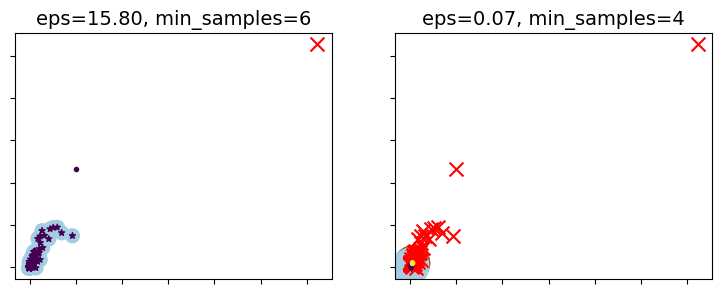

In [22]:
print(f"Cantidad de registros en data: {data.shape[0]}")
print(f"Cantidad de registros en data_clientes: {data_clientes.shape[0]}")

X = data_clientes_scaled

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100,show_ylabels=False, show_xlabels=False)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False, show_xlabels=False)


## Analisis de los resultados

Finalmente, realizamos un análisis de los clústeres obtenidos, observando las características de cada grupo (por ejemplo, los clientes de mayor valor, los que compran más cantidad, etc.).
Distribución de los clusters:

<ipython-input-23-e75c8c32a7bf>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_cont.index, y=cluster_cont.values, palette="viridis")
<ipython-input-23-e75c8c32a7bf>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_cont2.index, y=cluster_cont2.values, palette="magma")


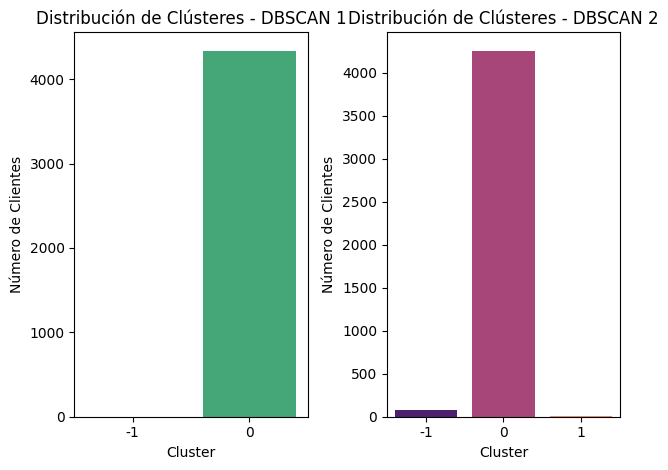

In [23]:
# Analizar las características de cada clúster
# Contar la cantidad de clientes en cada clúster para el primer modelo
cluster_cont = data_clientes['Cluster'].value_counts()
cluster_cont2 = data_clientes['Cluster2'].value_counts()

plt.subplot(1, 2, 1)
sns.barplot(x=cluster_cont.index, y=cluster_cont.values, palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Número de Clientes")
plt.title("Distribución de Clústeres - DBSCAN 1")

plt.subplot(1, 2, 2)
sns.barplot(x=cluster_cont2.index, y=cluster_cont2.values, palette="magma")
plt.xlabel("Cluster")
plt.ylabel("Número de Clientes")
plt.title("Distribución de Clústeres - DBSCAN 2")

plt.tight_layout()
plt.show()

In [24]:
# Agregar los clústeres al dataset original para el análisis
data_clientes['Cluster'] = dbscan.labels_
data_clientes['Cluster2'] = dbscan2.labels_

# Calcular estadísticas por clúster para DBSCAN 1
cluster_sum = data_clientes.groupby('Cluster').agg({
    'TotalValue': ['mean', 'median', 'sum', 'count'],
    'Quantity': ['mean', 'median', 'sum', 'count']
}).reset_index()

# Aplanar el índice multi-nivel
cluster_sum.columns = ['_'.join(col).strip() for col in cluster_sum.columns.values]
cluster_sum = cluster_sum.rename(columns={
    'Cluster_': 'Cluster',
    'TotalValue_mean': 'TotalValue_mean',
    'TotalValue_median': 'TotalValue_median',
    'TotalValue_sum': 'TotalValue_sum',
    'TotalValue_count': 'TotalValue_count',
    'Quantity_mean': 'Quantity_mean',
    'Quantity_median': 'Quantity_median',
    'Quantity_sum': 'Quantity_sum',
    'Quantity_count': 'Quantity_count'
})

# Calcular estadísticas por clúster para DBSCAN 2
cluster_sum2 = data_clientes.groupby('Cluster2').agg({
    'TotalValue': ['mean', 'median', 'sum', 'count'],
    'Quantity': ['mean', 'median', 'sum', 'count']
}).reset_index()

# Aplanar el índice multi-nivel
cluster_sum2.columns = ['_'.join(col).strip() for col in cluster_sum2.columns.values]
cluster_sum2 = cluster_sum2.rename(columns={
    'Cluster2_': 'Cluster2',
    'TotalValue_mean': 'TotalValue_mean',
    'TotalValue_median': 'TotalValue_median',
    'TotalValue_sum': 'TotalValue_sum',
    'TotalValue_count': 'TotalValue_count',
    'Quantity_mean': 'Quantity_mean',
    'Quantity_median': 'Quantity_median',
    'Quantity_sum': 'Quantity_sum',
    'Quantity_count': 'Quantity_count'
})

# Mostrar los resultados en formato tabla
print("Resumen de Clústeres - DBSCAN 1")
print(cluster_sum.to_string(index=False))

print("\nResumen de Clústeres - DBSCAN 2")
print(cluster_sum2.to_string(index=False))

Resumen de Clústeres - DBSCAN 1
 Cluster  TotalValue_mean  TotalValue_median  TotalValue_sum  TotalValue_count  Quantity_mean  Quantity_median  Quantity_sum  Quantity_count
      -1     1.733153e+06         1733152.52     1733152.520                 1  446738.000000         446738.0        446738               1
       0     2.053793e+03             674.45     8911407.904              4339    1194.214335            379.0       5181696            4339

Resumen de Clústeres - DBSCAN 2
 Cluster2  TotalValue_mean  TotalValue_median  TotalValue_sum  TotalValue_count  Quantity_mean  Quantity_median  Quantity_sum  Quantity_count
       -1     64961.552632           26301.98     4937078.000                76   30479.565789          13186.5       2316447              76
        0      1320.385392             657.80     5623521.384              4259     766.405025            368.0       3264119            4259
        1     16792.208000           16594.35       83961.040                 5    957

Si queremos trabajar con un análisis más simple y menos influenciado por valores atípicos, DBSCAN 1 es más adecuado, ya que tiene solo un clúster principal y el ruido es mínimo (solo un punto). Esto indica que los datos son bastante homogéneos y solo contienen algunos valores extremos.

Si necesitamos detallar más los grupos pequeños o identificar patrones específicos en pequeños conjuntos de datos (como el clúster 1 en DBSCAN 2), entonces DBSCAN 2 te proporcionará una mayor diferenciación entre grupos. Esto sugiere que DBSCAN ha identificado correctamente una subpoblación pequeña pero densa de datos que podrían tener una relación especial.

Si queremos simplificar y evitar ruido con un solo grupo claro, DBSCAN 1 es más adecuado. Si preferimos detallar más segmentos y no nos importa manejar más ruido, DBSCAN 2 podría ser el camino a seguir.


# Fin del programa